In [448]:
%pip install setuptools
%pip install ydata_profiling
%pip install scikit-learn
%pip install xlrd
%pip install openpyxl
%pip install ipywidgets
%pip install statsmodels
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [449]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from ydata_profiling import ProfileReport
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor
import catboost
from catboost import *
import statsmodels.api as sm

In [450]:
excel_data=pd.read_excel("././dataset/Объёмы перевозок.xls", skiprows=[0], header=[0,1])
excel_data_volumes = excel_data

In [451]:
excel_data_volumes.sort_index(axis=1, inplace=True)
num_col=len(excel_data_volumes.columns)
left = excel_data_volumes.iloc[:, [num_col-5, num_col-4, num_col-3, num_col-2,num_col-1]]
left.columns = left.columns.get_level_values(1)
left = left.set_axis(["id", "subj_from", "subj_to", "cargo_code", "cargo_type"], axis = 1)

In [452]:
labelencodder = LabelEncoder()
subj = pd.concat([left.loc[:, ["subj_from"]].rename(columns = {"subj_from": "subj"}), left.loc[:, ["subj_to"]].rename(columns = {"subj_to": "subj"})]).drop_duplicates(ignore_index=True)
cargo_type = left.loc[:, ["cargo_type"]].drop_duplicates(ignore_index=True)
subj.to_excel("././dataset/subj.xlsx")
cargo_type.to_excel("././dataset/cargo_type.xlsx")

In [453]:
left.loc[:, ["subj_from"]] = left.loc[:, ["subj_from"]].apply(lambda x: subj[subj["subj"] == x["subj_from"]].index[0], axis=1)
left.loc[:, ["subj_to"]] = left.loc[:, ["subj_to"]].apply(lambda x: subj[subj["subj"] == x["subj_to"]].index[0], axis=1)
left.loc[:, ["cargo_type"]] = left.loc[:, ["cargo_type"]].apply(lambda x: cargo_type[cargo_type["cargo_type"] == x["cargo_type"]].index[0], axis=1)

In [454]:
left["subj_from"] = left["subj_from"].astype("int64")
left["subj_to"] = left["subj_to"].astype("int64")
left["cargo_type"] = left["cargo_type"].astype("int64")

In [455]:
for i in range(int((num_col-5)/2)):
    right = excel_data_volumes.iloc[:, [i*2,i*2+1]]
    date = pd.to_datetime(excel_data_volumes.iloc[:, [i*2]].columns.get_level_values(0).to_list()[0], format="%Y/%m")
    
    right.insert(2, ("", "date"), date)
    right.insert(3, ("", "month"), date.month)
    right.insert(4, ("", "quarter"), date.quarter)
    right.insert(5, ("", "year"), date.year)
    right.columns = right.columns.get_level_values(1)
    right = right.set_axis(["cargo_volume", "cargo_sales", "date", "month", "quarter", "year"], axis=1)
    right.insert(2, ("cargo_price"), right.apply(lambda x: (x["cargo_sales"] / x["cargo_volume"]) if x["cargo_volume"] > 0 else x["cargo_sales"], axis= 1))
    if i == 0:
        result = pd.concat([left, right], axis = 1, sort = False)
    else:
        result = pd.concat([result, pd.concat([left, right], axis = 1, sort = False)], axis = 0, ignore_index=True, sort=False)
excel_data_volumes = result

In [456]:
excel_data_volumes.insert(12, ("month_of_period"), 0)

In [457]:
min = excel_data_volumes["year"].min()
excel_data_volumes["month_of_period"] = excel_data_volumes["year"].apply(lambda x: x - min)*12 + excel_data_volumes["month"] 
excel_data_volumes = excel_data_volumes.drop("date", axis = 1)

In [458]:
excel_data_volumes.to_excel("././dataset/volumes.xlsx")

In [459]:
excel_data_volumes

,id,subj_from,subj_to,cargo_code,cargo_type,cargo_volume,cargo_sales,cargo_price,month,quarter,year,month_of_period
0,21220,0,12,39146,0,0,0,0.000000,1,1,2022,1
1,912,1,13,32411,1,0,0,0.000000,1,1,2022,1
2,912,1,14,32411,1,476,1440050,3025.315126,1,1,2022,1
3,912,1,6,32411,1,0,0,0.000000,1,1,2022,1
4,912,1,12,32411,1,0,0,0.000000,1,1,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...
429595,11274,2,34,24116,2,136,81935,602.463235,8,3,2024,32
429596,20123,6,12,32411,1,397,871122,2194.261965,8,3,2024,32
429597,20123,6,17,32411,1,135,461477,3418.348148,8,3,2024,32
429598,20123,6,40,32411,1,600,1342809,2238.015000,8,3,2024,32


In [460]:
excel_data=pd.read_excel("././dataset/MC_1.xls", header=[0])
excel_data_MC = excel_data
excel_data=pd.read_excel("././dataset/MC_2.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_4.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_5.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_6.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_7.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_8.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)

In [461]:
excel_data_MC = excel_data_MC.drop(excel_data_MC.columns[[3,4,6,7,8,13,15,17]], axis = 1).drop_duplicates()
excel_data_MC = excel_data_MC.set_axis(["id", "is_msp", "company_size", "company_okved2", "els", "is_otpr", "is_poluch", "index_pl", "index_fin", "kontrakt_type"], axis=1)

In [462]:
excel_data_MC["is_msp"] = excel_data_MC["is_msp"].apply(lambda x: 1 if x == "Да" else 0)
excel_data_MC["is_otpr"] = excel_data_MC["is_otpr"].apply(lambda x: 1 if x == "Да" else 0) 
excel_data_MC["is_poluch"] = excel_data_MC["is_poluch"].apply(lambda x: 1 if x == "Да" else 0) 

In [463]:
excel_data_MC["company_size"] = excel_data_MC["company_size"].apply(lambda x: "Неизвестно" if x is np.nan else x)
excel_data_MC["company_okved2"] = excel_data_MC["company_okved2"].apply(lambda x: "0" if x is np.nan else x)
excel_data_MC["els"] = excel_data_MC["els"].apply(lambda x: 0 if x is np.nan else 1)
excel_data_MC["index_pl"] = excel_data_MC["index_pl"].apply(lambda x: "Недостаточно данных для расчета риска просрочки платежа" if x is np.nan else x)
excel_data_MC["index_fin"] = excel_data_MC["index_fin"].apply(lambda x: "Недостаточно данных для расчета индекса финансового риска" if x is np.nan else x)
excel_data_MC["kontrakt_type"] = excel_data_MC["kontrakt_type"].apply(lambda x: "Неизвестно" if x is np.nan else x)

In [464]:
company_size = excel_data_MC.loc[:, ["company_size"]].drop_duplicates(ignore_index=True)
company_size.to_excel("././dataset/company_size.xlsx")
index_pl = excel_data_MC.loc[:, ["index_pl"]].drop_duplicates(ignore_index=True)
index_pl.to_excel("././dataset/index_pl.xlsx")
index_fin = excel_data_MC.loc[:, ["index_fin"]].drop_duplicates(ignore_index=True)
index_fin.to_excel("././dataset/index_fin.xlsx")
kontrakt_type = excel_data_MC.loc[:, ["kontrakt_type"]].drop_duplicates(ignore_index=True)
kontrakt_type.to_excel("././dataset/kontrakt_type.xlsx")

In [465]:
excel_data_MC.loc[:, ["company_size"]] = excel_data_MC.loc[:, ["company_size"]].apply(lambda x: company_size[company_size["company_size"] == x["company_size"]].index[0], axis=1)
excel_data_MC.loc[:, ["index_pl"]] = excel_data_MC.loc[:, ["index_pl"]].apply(lambda x: index_pl[index_pl["index_pl"] == x["index_pl"]].index[0], axis=1)
excel_data_MC.loc[:, ["index_fin"]] = excel_data_MC.loc[:, ["index_fin"]].apply(lambda x: index_fin[index_fin["index_fin"] == x["index_fin"]].index[0], axis=1)
excel_data_MC.loc[:, ["kontrakt_type"]] = excel_data_MC.loc[:, ["kontrakt_type"]].apply(lambda x: kontrakt_type[kontrakt_type["kontrakt_type"] == x["kontrakt_type"]].index[0], axis=1)

In [466]:
excel_data_MC = excel_data_MC.drop_duplicates()

In [467]:
company_okved2 = excel_data_MC.groupby("id").apply(lambda x: list(set(list(x["company_okved2"]))), include_groups=False)
company_okved2 = company_okved2.reset_index().set_axis(["id", "company_okved2"], axis=1)  

In [468]:
is_msp = excel_data_MC.groupby("id").apply(lambda x: max(x["is_msp"]), include_groups=False)
is_msp = is_msp.reset_index().set_axis(["id", "is_msp"], axis=1) 

In [469]:
company_size = excel_data_MC.groupby("id").apply(lambda x: max(x["company_size"]), include_groups=False)
company_size = company_size.reset_index().set_axis(["id", "company_size"], axis=1)     

In [470]:
els = excel_data_MC.groupby("id").apply(lambda x: max(x["els"]), include_groups=False)
els = els.reset_index().set_axis(["id", "els"], axis=1)  

In [471]:
is_otpr = excel_data_MC.groupby("id").apply(lambda x: max(x["is_otpr"]), include_groups=False)
is_otpr = is_otpr.reset_index().set_axis(["id", "is_otpr"], axis=1)  

In [472]:
is_poluch = excel_data_MC.groupby("id").apply(lambda x: max(x["is_poluch"]), include_groups=False)
is_poluch = is_poluch.reset_index().set_axis(["id", "is_poluch"], axis=1) 

In [473]:
index_pl = excel_data_MC.groupby("id").apply(lambda x: max(x["index_pl"]), include_groups=False)
index_pl = index_pl.reset_index().set_axis(["id", "index_pl"], axis=1) 

In [474]:
index_fin = excel_data_MC.groupby("id").apply(lambda x: max(x["index_fin"]), include_groups=False)
index_fin = index_fin.reset_index().set_axis(["id", "index_fin"], axis=1) 

In [475]:
kontrakt_type = excel_data_MC.groupby("id").apply(lambda x: list(set(list(x["kontrakt_type"]))), include_groups=False)
kontrakt_type = kontrakt_type.reset_index().set_axis(["id", "kontrakt_type"], axis=1) 

In [476]:
id = excel_data_MC["id"].drop_duplicates()
id = id.reset_index().drop(columns=["index"])

In [477]:
excel_data_MC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9512 entries, 0 to 183206
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              9512 non-null   int64 
 1   is_msp          9512 non-null   int64 
 2   company_size    9512 non-null   object
 3   company_okved2  9512 non-null   object
 4   els             9512 non-null   int64 
 5   is_otpr         9512 non-null   int64 
 6   is_poluch       9512 non-null   int64 
 7   index_pl        9512 non-null   object
 8   index_fin       9512 non-null   object
 9   kontrakt_type   9512 non-null   object
dtypes: int64(5), object(5)
memory usage: 817.4+ KB


In [478]:
excel_data = pd.merge(id, is_msp, left_on="id", right_on="id")


In [479]:
excel_data = pd.merge(excel_data, company_size, left_on="id", right_on="id")

In [480]:
excel_data = pd.merge(excel_data, company_okved2, left_on="id", right_on="id")

In [481]:
excel_data = pd.merge(excel_data, els, left_on="id", right_on="id")

In [482]:
excel_data = pd.merge(excel_data, is_otpr, left_on="id", right_on="id")

In [483]:
excel_data = pd.merge(excel_data, is_poluch, left_on="id", right_on="id")

In [484]:
excel_data = pd.merge(excel_data, index_pl, left_on="id", right_on="id")

In [485]:
excel_data = pd.merge(excel_data, index_fin, left_on="id", right_on="id")

In [486]:
excel_data = pd.merge(excel_data, kontrakt_type, left_on="id", right_on="id")

In [487]:
excel_data_MC = excel_data

In [488]:
excel_data_MC.to_excel("././dataset/MC.xlsx")

In [489]:
excel_data_MC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9267 entries, 0 to 9266
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              9267 non-null   int64 
 1   is_msp          9267 non-null   int64 
 2   company_size    9267 non-null   int64 
 3   company_okved2  9267 non-null   object
 4   els             9267 non-null   int64 
 5   is_otpr         9267 non-null   int64 
 6   is_poluch       9267 non-null   int64 
 7   index_pl        9267 non-null   int64 
 8   index_fin       9267 non-null   int64 
 9   kontrakt_type   9267 non-null   object
dtypes: int64(8), object(2)
memory usage: 724.1+ KB


In [490]:
data_pd = excel_data_volumes.drop("subj_from", axis = 1)
data_pd = data_pd.drop("subj_to", axis = 1)
data_pd = data_pd.drop("cargo_code", axis = 1)
data_pd = data_pd.drop("cargo_type", axis = 1)


In [491]:
data_pd = data_pd.groupby(["id", "month_of_period", "year", "quarter", "month" ], as_index=False).sum()

In [492]:
data_pd["innactive"] = 0
data_pd["active"] = 0
data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_sales"] == 0)) else 0, axis=1)
data_pd["active"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] > 0) & (x["cargo_sales"] > 0)) else 0, axis=1)

In [493]:
data_pd.head(10)

,id,month_of_period,year,quarter,month,cargo_volume,cargo_sales,cargo_price,innactive,active
0,9,1,2022,1,1,0,0,0.00000,1,0
1,9,2,2022,1,2,0,0,0.00000,1,0
2,9,3,2022,1,3,0,0,0.00000,1,0
3,9,4,2022,2,4,0,0,0.00000,1,0
4,9,5,2022,2,5,0,0,0.00000,1,0
5,9,6,2022,2,6,0,0,0.00000,1,0
6,9,7,2022,3,7,0,0,0.00000,1,0
7,9,8,2022,3,8,0,0,0.00000,1,0
8,9,9,2022,3,9,61,155364,2546.95082,0,1
9,9,10,2022,4,10,0,0,0.00000,1,0


In [494]:
data_pd["outflow"] = 0

def calc_innactive(row):
    prev_row_value = 0
    row_value = data_pd.iloc[row.name]["innactive"]
    row_id = data_pd.iloc[row.name]["id"]
    if row.name > 0:
        prev_row_id = data_pd.iloc[row.name - 1]["id"]
        if row_id == prev_row_id:
            if  row_value > 0:
                prev_row_value = data_pd.iloc[row.name - 1]["innactive"]
                data_pd.iloc[row.name, data_pd.columns.get_loc("innactive")] = prev_row_value + 1
                row_value = data_pd.iloc[row.name]["innactive"]
                if row_value > 11:
                    prev_row_value = 1
                else:
                    prev_row_value = row_value/12
            else: 
                prev_row_value = 0
    return prev_row_value

def calc_active(row):
    row_value = data_pd.iloc[row.name]["active"]
    row_id = data_pd.iloc[row.name]["id"]
    if row.name > 0:
        prev_row_id = data_pd.iloc[row.name - 1]["id"]
        if row_id == prev_row_id:
            if  row_value > 0:
                prev_row_value = data_pd.iloc[row.name - 1]["active"]
                data_pd.iloc[row.name, data_pd.columns.get_loc("active")] = prev_row_value + 1
    return 0

data_pd["outflow"] = data_pd.apply(calc_innactive, axis=1)
# data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_sales"] == 0)) else 0, axis=1)
data_pd.apply(calc_active, axis=1)


0        0
1        0
2        0
3        0
4        0
        ..
30587    0
30588    0
30589    0
30590    0
30591    0
Length: 30592, dtype: int64

In [495]:
data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_sales"] == 0)) else 0, axis=1)
data_pd["active"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] > 0) & (x["cargo_sales"] > 0)) else 0, axis=1)

In [496]:
excel_data = data_pd[data_pd["month_of_period"] == max(data_pd["month_of_period"])].loc[:, ["id", "outflow"]].reset_index()

In [497]:
excel_data = excel_data.drop(columns = ["index"])

In [498]:
excel_data["outflow"] = excel_data["outflow"].apply(lambda x: 1 if x ==1 else 0)

In [499]:
data_pd = data_pd.drop(columns = ["month_of_period", "year", "quarter", "month", "outflow"]).groupby(["id"]).sum()

In [500]:
data_pd["activity"] = data_pd.apply(lambda x: x["active"]/(x["active"]+x["innactive"]), axis = 1)

In [501]:
data_pd = data_pd.drop(columns=["innactive", "active"])

In [502]:
data_pd

,cargo_volume,cargo_sales,cargo_price,activity
id,,,,
9,216,663977,1.241603e+04,0.12500
25,186332,83893559,1.122309e+05,1.00000
33,157844,463772680,4.176032e+06,1.00000
86,1664,2817957,5.001043e+03,0.09375
115,162887,391321720,1.184122e+06,1.00000
...,...,...,...,...
21725,12,30200,5.033333e+03,0.06250
21726,244,737941,6.073666e+03,0.06250
21727,3183,8943212,5.624780e+03,0.03125


In [503]:
data_pd = pd.merge(data_pd, excel_data, left_on="id", right_on="id")

In [504]:
data_pd = data_pd.drop(columns=["cargo_price"])

In [505]:
data_pd = data_pd.rename(columns = {"outflow" : "out"})

In [506]:
data_pd

,id,cargo_volume,cargo_sales,activity,out
0,9,216,663977,0.12500,0
1,25,186332,83893559,1.00000,0
2,33,157844,463772680,1.00000,0
3,86,1664,2817957,0.09375,1
4,115,162887,391321720,1.00000,0
...,...,...,...,...,...
951,21725,12,30200,0.06250,0
952,21726,244,737941,0.06250,0
953,21727,3183,8943212,0.03125,0
954,21728,48,247392,0.12500,0


In [507]:
excel_data_MC

,id,is_msp,company_size,company_okved2,els,is_otpr,is_poluch,index_pl,index_fin,kontrakt_type
0,864,0,0,[0],0,0,0,0,0,[0]
1,865,0,0,[0],1,0,0,0,0,[0]
2,866,0,0,[0],1,0,1,0,0,[0]
3,867,0,0,[0],0,0,0,0,0,[0]
4,868,0,0,[0],0,0,0,0,0,[0]
...,...,...,...,...,...,...,...,...,...,...
9262,11186,0,0,[0],0,0,0,0,0,[0]
9263,11187,0,0,[0],0,0,0,0,0,[0]
9264,11188,0,0,[0],0,0,0,0,0,[0]
9265,11189,0,0,[0],0,0,0,0,0,[0]


In [508]:
excel_data = pd.merge(excel_data_MC, data_pd, left_on="id", right_on="id", how="outer")

In [509]:
excel_data

,id,is_msp,company_size,company_okved2,els,is_otpr,is_poluch,index_pl,index_fin,kontrakt_type,cargo_volume,cargo_sales,activity,out
0,0,0.0,4.0,[0],1.0,0.0,0.0,0.0,0.0,[0],NaN,NaN,NaN,NaN
1,1,0.0,0.0,[0],1.0,0.0,0.0,0.0,0.0,[0],NaN,NaN,NaN,NaN
2,2,0.0,0.0,[0],1.0,0.0,0.0,0.0,0.0,[0],NaN,NaN,NaN,NaN
3,3,0.0,0.0,[0],0.0,0.0,0.0,0.0,0.0,[0],NaN,NaN,NaN,NaN
4,4,0.0,0.0,[0],0.0,0.0,0.0,0.0,0.0,[0],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,21725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,30200.0,0.06250,0.0
9995,21726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244.0,737941.0,0.06250,0.0
9996,21727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3183.0,8943212.0,0.03125,0.0
9997,21728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,247392.0,0.12500,0.0


In [510]:
excel_data = excel_data[excel_data["out"].notna()]

In [511]:
excel_data.loc[:, ["is_msp"]] = excel_data.loc[:, ["is_msp"]].fillna(0).astype("int64")

In [512]:
excel_data.loc[:, ["company_size"]] = excel_data.loc[:, ["company_size"]].fillna(0).astype("int64")

In [513]:
excel_data.loc[:, ["company_okved2"]] = excel_data.loc[:, ["company_okved2"]].fillna(0).apply(lambda x: x["company_okved2"] if x["company_okved2"] !=0 else [0], axis =1)

In [514]:
excel_data.loc[:, ["els"]] = excel_data.loc[:, ["els"]].fillna(0).astype("int64")

In [515]:
excel_data.loc[:, ["is_otpr"]] = excel_data.loc[:, ["is_otpr"]].fillna(1).astype("int64")

In [516]:
excel_data.loc[:, ["is_poluch"]] = excel_data.loc[:, ["is_poluch"]].fillna(0).astype("int64")

In [517]:
excel_data.loc[:, ["index_pl"]] = excel_data.loc[:, ["index_pl"]].fillna(0).astype("int64")

In [518]:
excel_data.loc[:, ["index_fin"]] = excel_data.loc[:, ["index_fin"]].fillna(0).astype("int64")

In [519]:
excel_data.loc[:, ["kontrakt_type"]] = excel_data.loc[:, ["kontrakt_type"]].fillna(0).apply(lambda x: x["kontrakt_type"] if x["kontrakt_type"] !=0 else [0], axis =1)

In [520]:
excel_data = excel_data.reset_index().drop(columns=["index"])

In [521]:
excel_data.loc[:, ["company_okved2"]] = excel_data.loc[:, ["company_okved2"]].apply(lambda x: ', '.join(str(element) for element in x["company_okved2"]), axis=1)

In [522]:
company_okved2 = excel_data.loc[:, ["company_okved2"]].drop_duplicates(ignore_index=True)
company_okved2.to_excel("././dataset/company_okved2.xlsx")

In [523]:
excel_data.loc[:, ["company_okved2"]] = excel_data.loc[:, ["company_okved2"]].apply(lambda x: company_okved2[company_okved2["company_okved2"] == x["company_okved2"]].index[0], axis=1)

In [524]:
excel_data.loc[:, ["kontrakt_type"]] = excel_data.loc[:, ["kontrakt_type"]].apply(lambda x: ', '.join(str(element) for element in x["kontrakt_type"]), axis=1).astype("str")

In [525]:
kontrakt_type = excel_data.loc[:, ["kontrakt_type"]].drop_duplicates(ignore_index=True)
kontrakt_type.to_excel("././dataset/kontrakt_type.xlsx")

In [526]:
excel_data.loc[:, ["kontrakt_type"]] = excel_data.loc[:, ["kontrakt_type"]].apply(lambda x: kontrakt_type[kontrakt_type["kontrakt_type"] == x["kontrakt_type"]].index[0], axis=1)

In [527]:
excel_data = excel_data.convert_dtypes()
excel_data.to_excel("././dataset/merge_data.xlsx")

In [528]:
excel_data = excel_data.drop(columns=["is_otpr"])

In [529]:
excel_data["price"] = round(excel_data["cargo_sales"] / excel_data["cargo_volume"]).astype("int64")

In [531]:
excel_data = excel_data.drop(columns=["cargo_sales"])

In [532]:
excel_data["cargo_volume"] = np.log(excel_data["cargo_volume"])

In [533]:
excel_data = excel_data.convert_dtypes()

In [534]:
excel_data

,id,is_msp,company_size,company_okved2,els,is_poluch,index_pl,index_fin,kontrakt_type,cargo_volume,activity,out,price
0,9,0,4,0,1,1,0,1,0,5.375278,0.125,0,3074
1,25,0,1,1,1,1,0,1,1,12.135285,1.0,0,450
2,33,0,2,2,1,1,1,1,1,11.969362,1.0,0,2938
3,86,0,0,3,1,1,0,0,0,7.41698,0.09375,1,1693
4,115,0,2,4,1,1,1,1,1,12.000812,1.0,0,2402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,21725,0,0,3,0,0,0,0,0,2.484907,0.0625,0,2517
952,21726,0,0,3,0,0,0,0,0,5.497168,0.0625,0,3024
953,21727,0,0,3,0,0,0,0,0,8.065579,0.03125,0,2810
954,21728,0,0,3,0,0,0,0,0,3.871201,0.125,0,5154


In [535]:
excel_data = excel_data[[c for c in excel_data if c not in ['out']] 
       + ['out']]

In [536]:
ProfileReport(excel_data, minimal = True) # Формирование отчета для исследования данных

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [590]:
excel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              956 non-null    Int64  
 1   is_msp          956 non-null    Int64  
 2   company_size    956 non-null    Int64  
 3   company_okved2  956 non-null    Int64  
 4   els             956 non-null    Int64  
 5   is_poluch       956 non-null    Int64  
 6   index_pl        956 non-null    Int64  
 7   index_fin       956 non-null    Int64  
 8   kontrakt_type   956 non-null    Int64  
 9   cargo_volume    956 non-null    Float64
 10  activity        956 non-null    Float64
 11  price           956 non-null    Int64  
 12  out             956 non-null    Int64  
dtypes: Float64(2), Int64(11)
memory usage: 109.4 KB


In [592]:
excel_data.drop(columns = ["id", "els", "is_msp", "company_size", "company_okved2", "index_pl", "index_fin"]).groupby(by = "out").mean() # расчет средних значений признаков для тех кто ушел и остался

,is_poluch,kontrakt_type,cargo_volume,activity,price
out,,,,,
0,0.209335,0.149929,8.471989,0.579878,3068.435644
1,0.128514,0.084337,5.820071,0.125879,3514.26506


<Axes: >

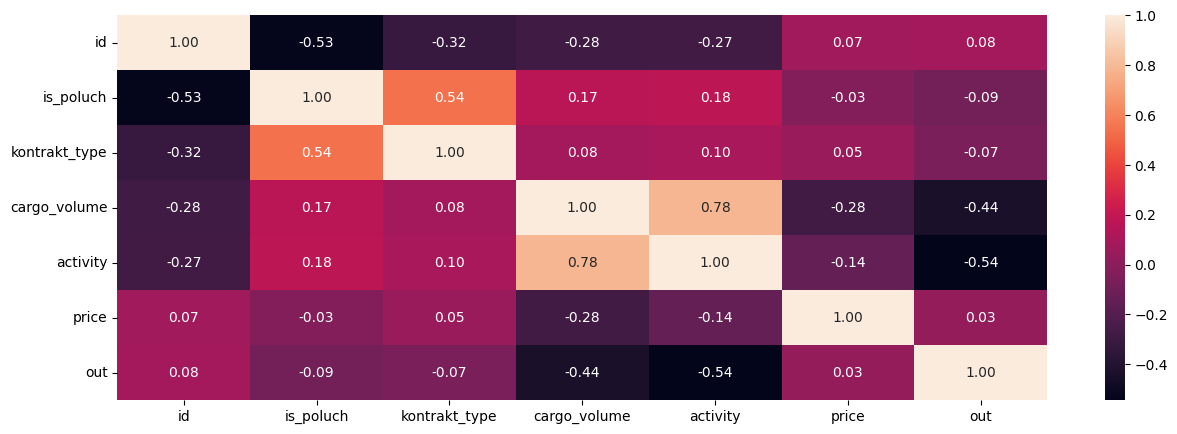

In [593]:
cor = excel_data.drop(columns = ["els", "is_msp", "company_size", "company_okved2", "index_pl", "index_fin"]).corr() # матрица корреляций
fig, ax = plt.subplots(figsize=(15,5)) 
sns.heatmap(cor, annot = True, fmt = ".2f") # тепловая карта на основе матрицы корреляций

In [611]:
fit_pd = excel_data.drop(columns = ["els", "is_msp", "company_size", "company_okved2", "index_pl", "index_fin"])

In [612]:
keep = fit_pd['id'].drop_duplicates().sample(frac=0.7)
m = fit_pd['id'].isin(keep)
train = fit_pd[m].drop("id", axis=1)
test = fit_pd[~m].drop("id", axis=1)

train.to_excel("train.xlsx")
test.to_excel("test.xlsx")

In [ ]:
X_train = train.drop("out", axis = 1)
y_train = train["out"] # разделение данных на признаки (матрица X) и целевую переменную (y)
X_test = test.drop("out", axis = 1)
y_test = test["out"] # разделение данных на признаки (матрица X) и целевую переменную (y)



In [630]:
model = LogisticRegression(max_iter = 1000)  
model.fit(X_train,y_train)
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, predictions)
precision = precision_score (y_test, predictions)
recall = recall_score (y_test, predictions)
print(acc, precision, recall) # вывод на экран метрик, характеризующих качество модели

0.8083623693379791 0.675 0.6506024096385542


In [631]:
rf_model = RandomForestClassifier(n_estimators = 1000)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test) 
acc_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score (y_test, y_pred)
recall_rf = recall_score (y_test, y_pred)
print(acc_rf, precision_rf, recall_rf)# вывод на экран метрик, характеризующих качество модели

0.794425087108014 0.6578947368421053 0.6024096385542169


In [660]:
df = pd.DataFrame(predictions, columns =['out'])
df

,out
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
282,1.0
283,0.0
284,1.0
285,1.0


In [662]:
X = pd.concat([X_test.reset_index(), df], axis=1).drop(columns = ["index"])

In [663]:
X

,is_poluch,kontrakt_type,cargo_volume,activity,price,out
0,1,0,5.375278,0.125,3074,0.0
1,1,1,12.135285,1.0,450,0.0
2,1,0,7.41698,0.09375,1693,0.0
3,0,1,6.180017,0.53125,3763,0.0
4,1,0,7.810353,0.125,5381,0.0
...,...,...,...,...,...,...
282,0,0,2.772589,0.03125,14638,1.0
283,0,0,7.044033,0.09375,4809,0.0
284,0,0,7.053586,0.03125,1817,1.0
285,0,0,2.484907,0.0625,2517,1.0


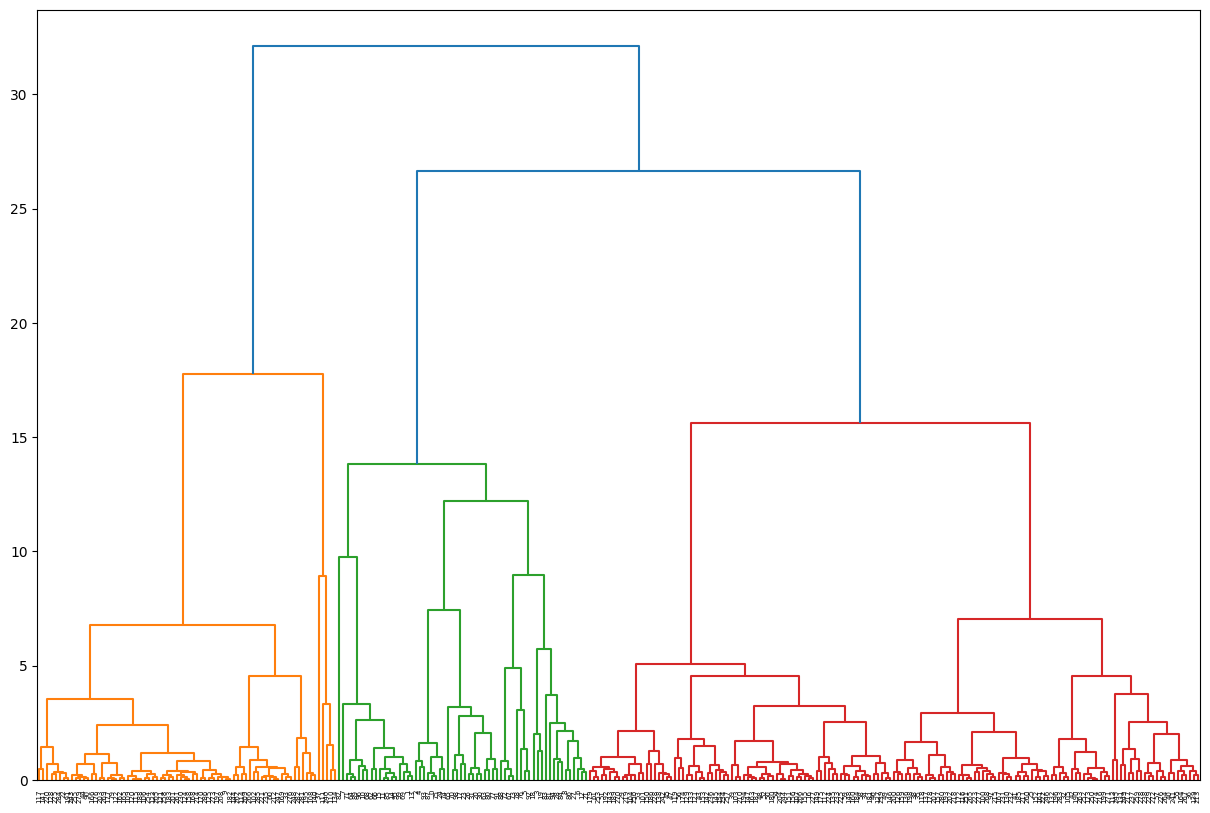

In [664]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = "ward")
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation="top")
plt.show() # вывод на экран дендрограммы

In [665]:
cl = 3 # количество кластеров выбранов соответствии с дендрограммой, а также на основе анализа нескольких вариантов
km = KMeans(n_clusters = cl)
labels = km.fit_predict(X_sc)

In [666]:
X["claster"]= labels # добавление колонки с категориями

In [667]:
piv = pd.pivot_table(data = X, index = "claster", columns = "out", values = "activity", aggfunc = "count" ).reset_index() # формирование сводной таблицы для анализа оттока по категориям
piv.columns = ["claster","out_0","out_1"]
piv["perc"] = piv["out_1"]/(piv["out_0"]+piv["out_1"])
piv["number"]=piv["out_1"]+piv["out_0"]
print(piv.head())

   claster  out_0  out_1      perc  number
0        0      2     77  0.974684      79
1        1    154   <NA>      <NA>    <NA>
2        2     51      3  0.055556      54


<Axes: >

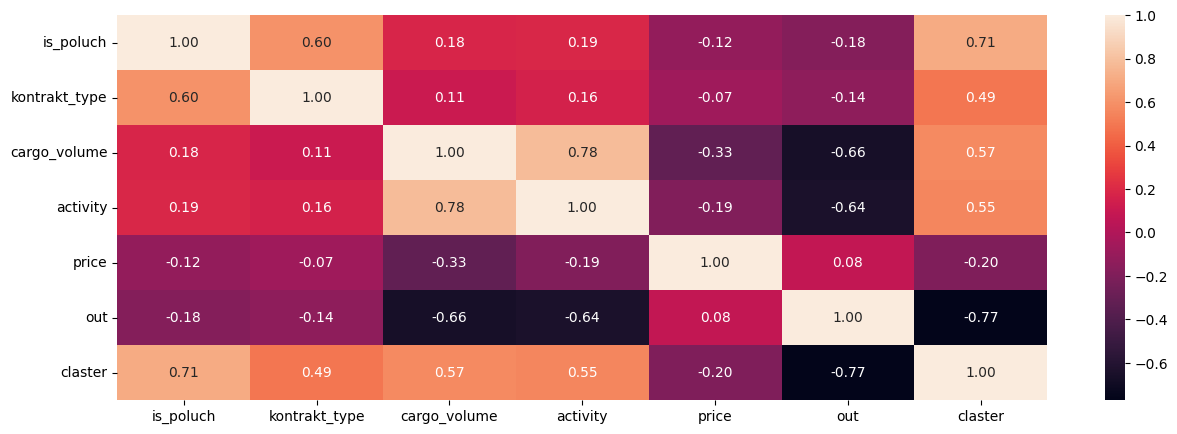

In [668]:
cor = X.corr()
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(cor, annot = True, fmt = ".2f")

In [669]:
X

,is_poluch,kontrakt_type,cargo_volume,activity,price,out,claster
0,1,0,5.375278,0.125,3074,0.0,2
1,1,1,12.135285,1.0,450,0.0,2
2,1,0,7.41698,0.09375,1693,0.0,2
3,0,1,6.180017,0.53125,3763,0.0,1
4,1,0,7.810353,0.125,5381,0.0,2
...,...,...,...,...,...,...,...
282,0,0,2.772589,0.03125,14638,1.0,0
283,0,0,7.044033,0.09375,4809,0.0,1
284,0,0,7.053586,0.03125,1817,1.0,0
285,0,0,2.484907,0.0625,2517,1.0,0


In [ ]:
# excel_data = excel_data.drop(columns = ["claster"])